# Dynamic Modeling

Use the generalized dynamical model to solve the full transcriptional dynamics. This yields additional insights such as latent time and identification of putative driver genes. Applied to endocrine development in the pancreas.

In [1]:
import scvelo as scv
scv.logging.print_version()

/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Running scvelo 0.3.1 (python 3.11.6) on 2024-01-24 10:10.


In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.settings.set_figure_params('scvelo')

## Prepare the data

Gene selection, normalizing by total size, logarithmizing X, and computing moments for velocity estimation.

In [4]:
adata = scv.datasets.pancreas()

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/home/mesqueda/miniconda3/envs/scanpy/lib/python3.11/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Dynamical Model

Run the dynamical model to learn the full transcriptional dynamics of splicing kinetics.

It is solved in a likelihood-based expectation-maximization framework, by iteratively estimating the parameters of reaction rates and latent cell-specific variables, i.e. transcrional state and cell-internal latent time. It aims to learn the unspliced/spliced phase trajectory for each gene. 

In [6]:
scv.tl.recover_dynamics(adata)

recovering dynamics (using 1/16 cores)


  0%|          | 0/1298 [00:00<?, ?gene/s]

    finished (0:06:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [7]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/16 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


Running the dynamical model can take a while. Store the results for re-use with `adata.write('data/pancrease.h5ad', compression=gzip)`, which can later be read with `adata = scv.read('data/pancrease.h5ad')`.

In [8]:
#adata.write('data/pancreas.h5ad', compression='gzip')
#adata = scv.read('data/pancreas.h5ad')

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


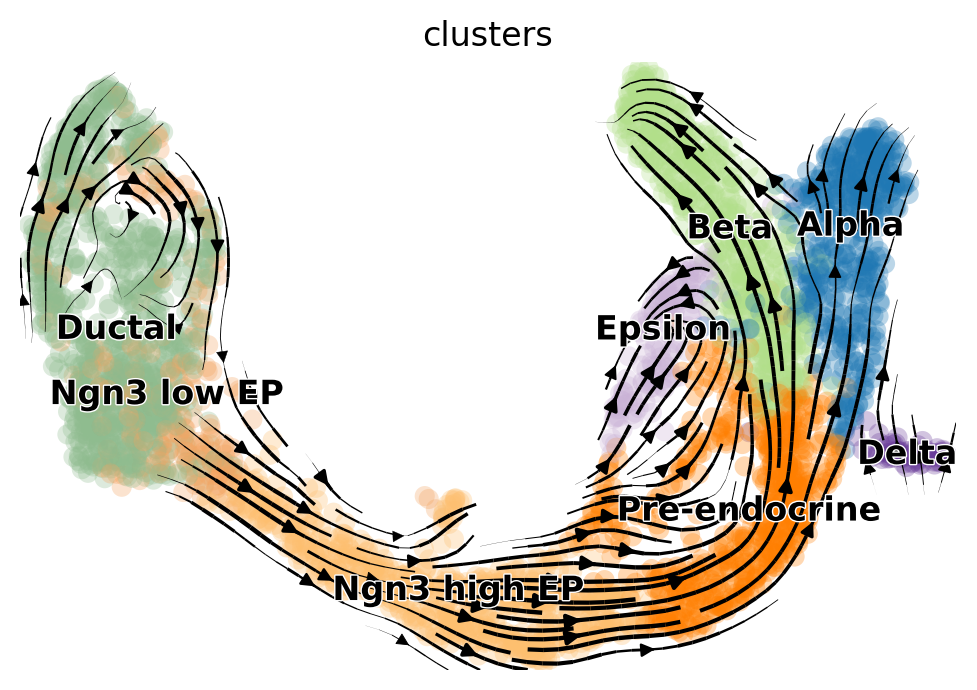

In [9]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

## Kinetic rate parameters

The rates of RNA transcription, splicing, and degredation are estimated without the need of any experimental data. These can be useful to better understand the cell identity and phenotypic heterogeneity.

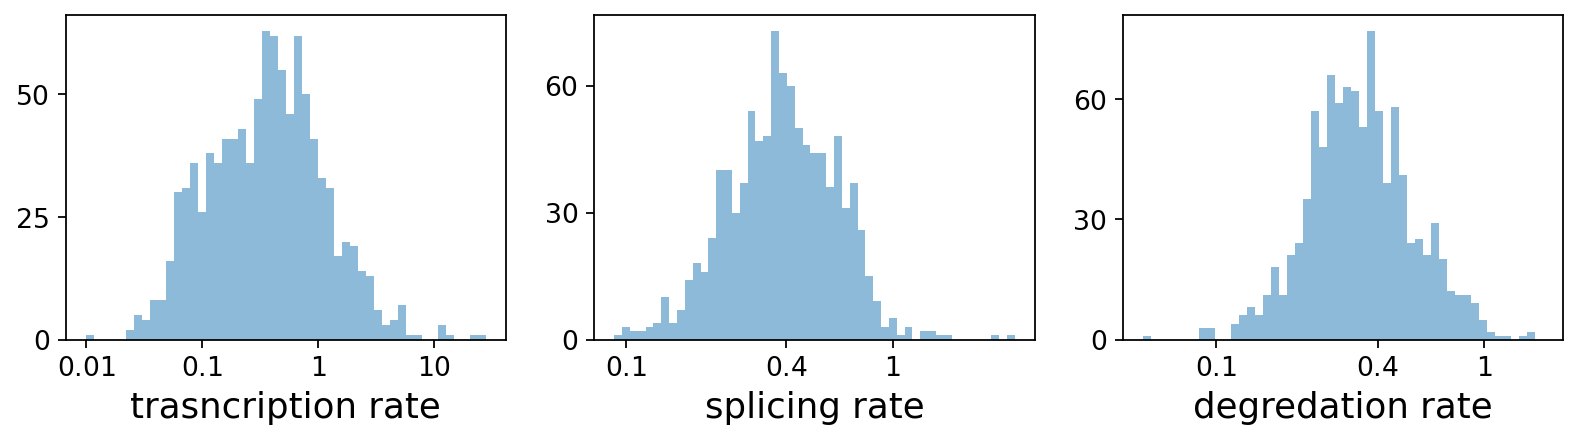

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
index,,,,,,,,,,,,,,,,
Sntg1,0.401981,0.015726,0.005592,0.088792,23.404254,42.849447,1.029644,0.030838,0.406523,0.0,0.0,0.159472,2.470675,0.094304,0.149138,5.355590
Snhg6,0.125072,0.389126,2.981982,0.260322,6.981600,0.070368,0.037113,0.245248,0.243441,0.0,0.0,0.403409,0.106128,0.596630,0.762252,2.037296
Sbspon,0.624803,0.464865,2.437113,0.379645,3.785993,0.154771,0.058587,0.178859,0.252135,0.0,0.0,0.182088,0.164805,0.430623,0.674312,1.193015
Mcm3,0.292389,3.096367,39.995796,0.638543,2.049463,0.013943,0.016253,0.673142,0.228207,0.0,0.0,0.467683,0.051432,1.927742,0.687468,0.887607
Fam135a,0.384662,0.172335,0.118088,0.204538,11.239574,1.124040,0.356525,0.149868,0.283343,0.0,0.0,0.387921,1.345830,0.393197,0.671096,3.390194


In [11]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='trasncription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degredation rate', xticks=[.1, .4, 1], **kwargs)
    
scv.get_df(adata, 'fit*', dropna=True).head()

## Latent time

The dynamic model recovers the latent time of the underlying cellular processes. This latent time represents the cell's internal clock and approximates the real time experienced by cells as they differentiate, based only on its transcriptional dynamics.

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


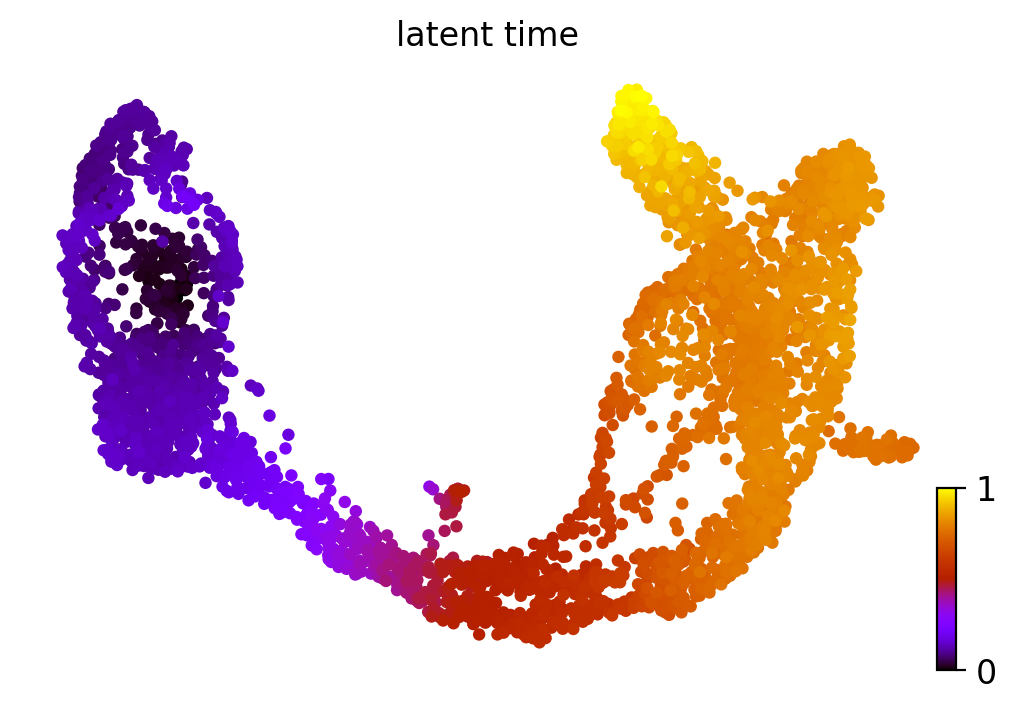

In [12]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

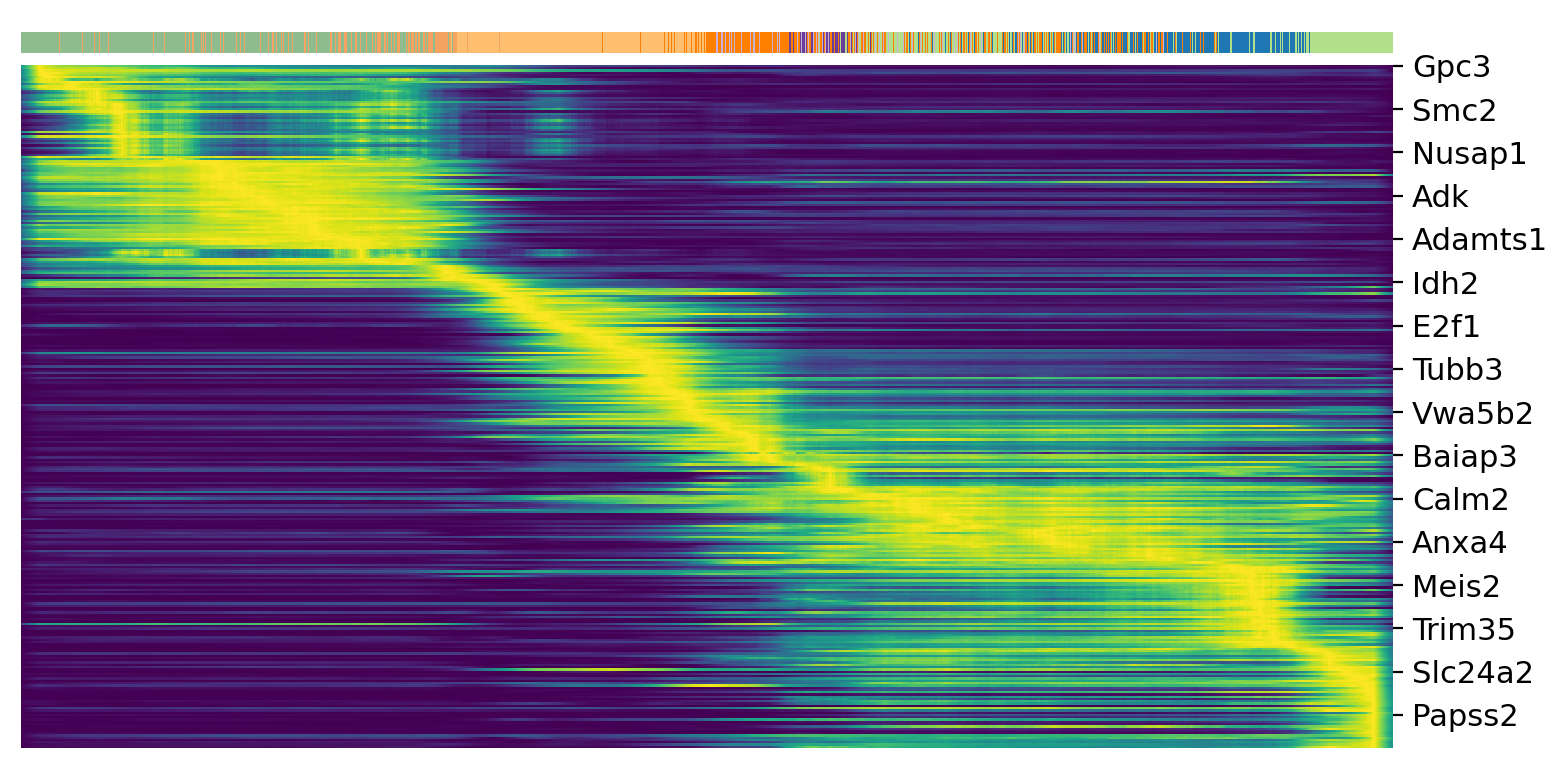

In [14]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='clusters', n_convolve=100)

## Top-likelihood genes

Driver genes display pronounced dynamic behavior and are systematically detected via their characterization by high likelihoods in the dynamic model.

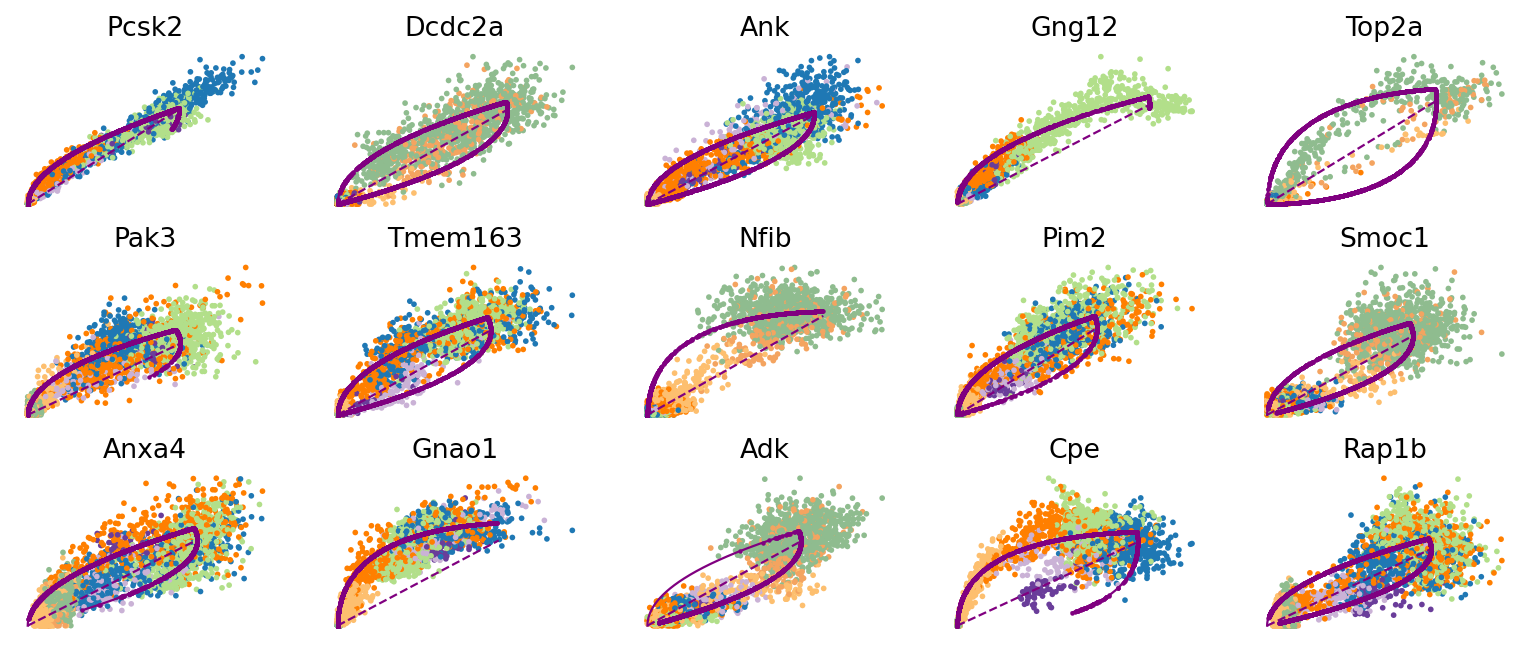

In [15]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

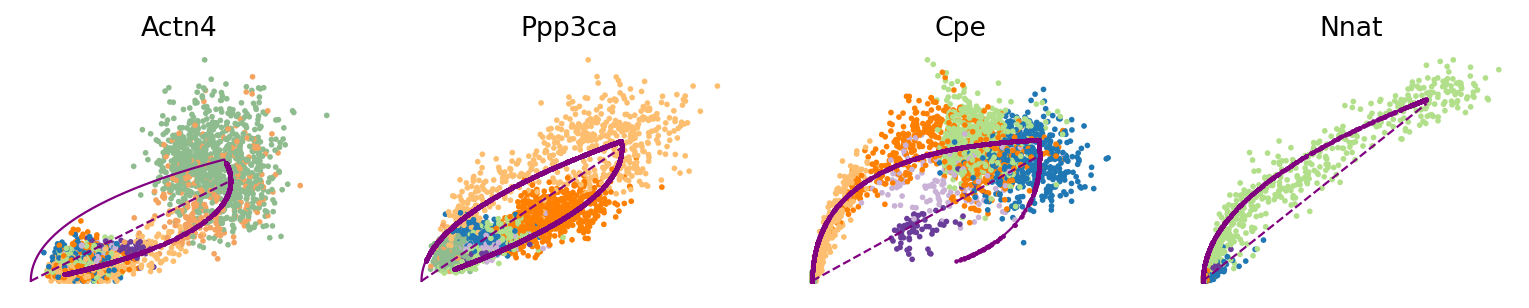

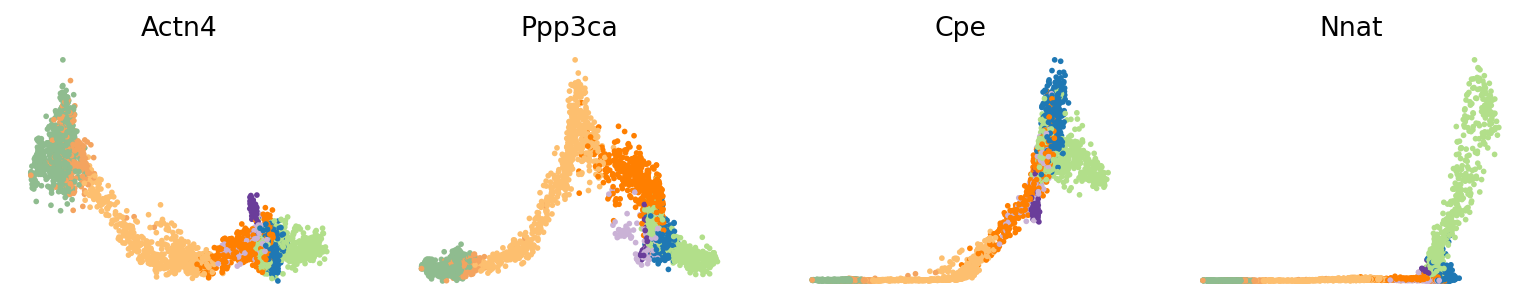

In [17]:
var_names = ['Actn4', 'Ppp3ca', 'Cpe', 'Nnat']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

## Cluster-specific top-likelihood genes

Partial gene likelihoods can be computed for each cluster of cells to enable cluster-specfic identification of potential drivers.

In [18]:
scv.tl.rank_dynamical_genes(adata, groupby='clusters')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

ranking genes by cluster-specific likelihoods
    finished (0:00:03) --> added 
    'rank_dynamical_genes', sorted scores by group ids (adata.uns)


,Ductal,Ngn3 low EP,Ngn3 high EP,Pre-endocrine,Beta,Alpha,Delta,Epsilon
0,Dcdc2a,Dcdc2a,Rbfox3,Abcc8,Pcsk2,Cpe,Pcsk2,Tox3
1,Top2a,Adk,Mapre3,Tmem163,Ank,Gnao1,Rap1b,Rnf130
2,Nfib,Mki67,Btbd17,Gnao1,Tmem163,Pak3,Pak3,Meis2
3,Wfdc15b,Rap1gap2,Sulf2,Ank,Tspan7,Pim2,Abcc8,Adk
4,Cdk1,Top2a,Tcp11,Tspan7,Map1b,Map1b,Klhl32,Rap1gap2


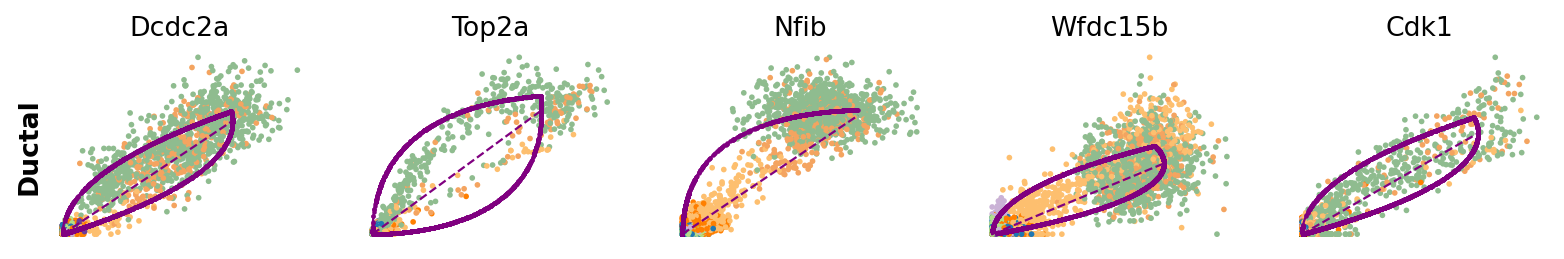

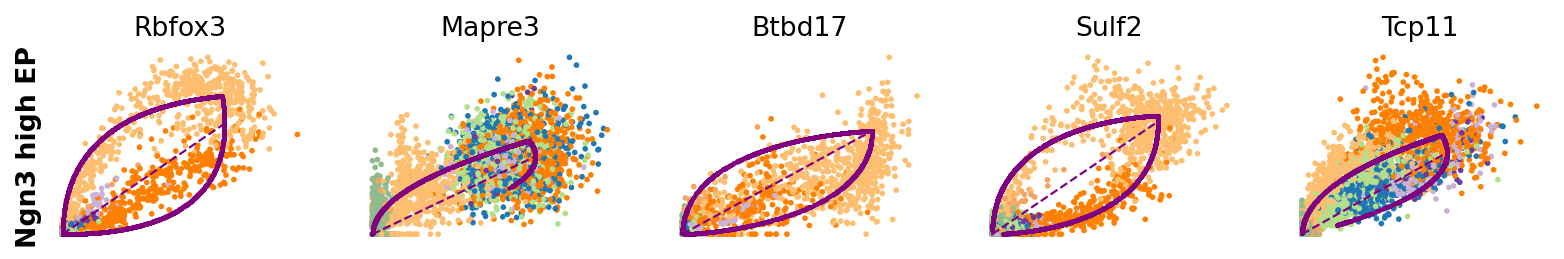

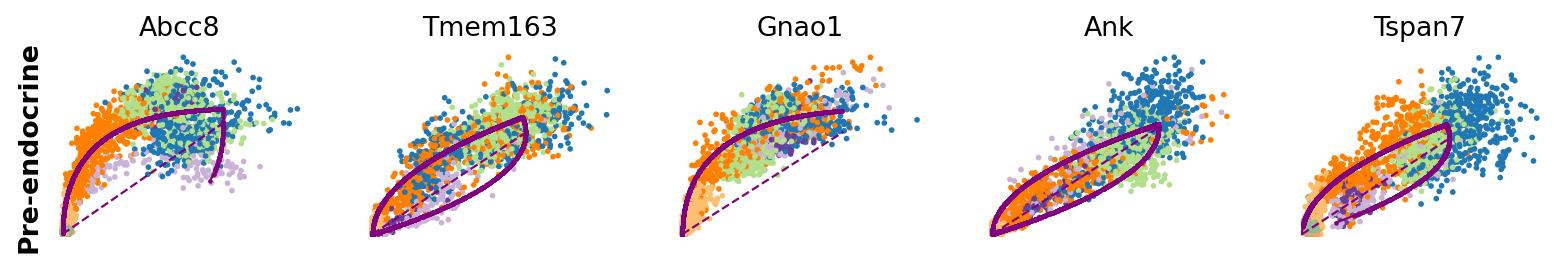

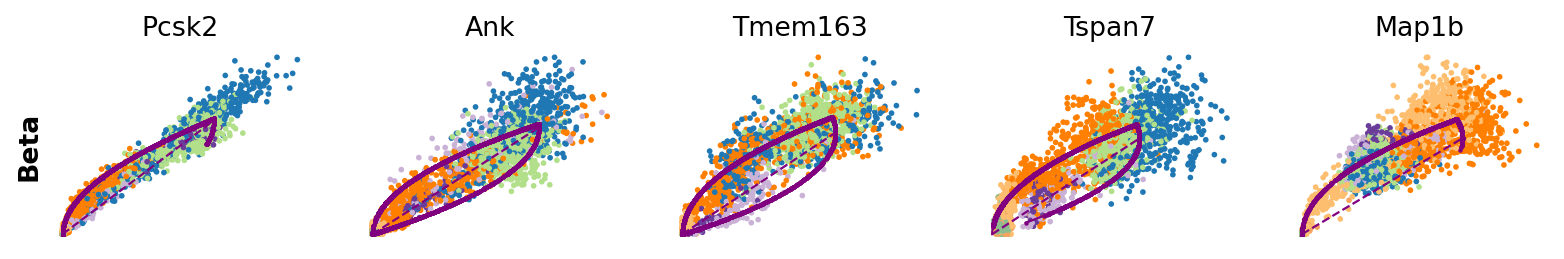

In [19]:
for cluster in ['Ductal', 'Ngn3 high EP', 'Pre-endocrine', 'Beta']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=cluster, frameon=False)